In [1]:
from torchvision.datasets import SVHN
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import torch.nn as nn
import torchvision
import torch
from torch import optim
import time
# vgg默认图片输入大小为224*224*3，要用SGD

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/SVHN'
mean = [0.4377, 0.4438, 0.4728]
std = [0.1980, 0.2010, 0.1970]
data_train = SVHN(data_root,
                   split='train',
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]))
data_test = SVHN(data_root,
                  split='test',
                  download=True,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]))

Using downloaded and verified file: ./autodl-tmp/SVHN/train_32x32.mat
Using downloaded and verified file: ./autodl-tmp/SVHN/test_32x32.mat


In [3]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [5]:
net = torchvision.models.vgg16(pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=2e-3, momentum=0.9, weight_decay=0.001)  #2e-3会立马收敛
# 动态更新学习率------每隔step_size : lr = lr * gamma
schedule = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5, last_epoch=-1)

In [ ]:
len(data_train)

In [6]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    # 每一轮结束输出一下当前的学习率 lr
    lr_1 = optimizer.param_groups[0]['lr']
    print("learn_rate:%.15f" % lr_1)
    schedule.step()
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [7]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [8]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [9]:
epoch = 100
acc, loss, val_acc, val_loss = [], [], [], []

start = time.time()
for e in range(epoch):
    #if e>=20 and e<50:
     #   optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.001)
    #elif e>=50:
     #   optimizer = ooptim.SGD(net.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.001)
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')
    if e % 10 == 0:
        torch.save(net.state_dict(), f'autodl-tmp/save_model/svhn/vgg16/epoch={e}_test_acc={c:0.3f}.pth')
end = time.time()
# 计算并打印输出你的训练时间
print("total time:{}".format(end - start))

training...
learn_rate:0.002000000000000
Train Avg. Loss: 2.732923, Accuracy: 0.165486
Test Avg. Loss: 2.237730, Accuracy: 0.195874
lenet_epoch=0 test_acc=0.196
training...
learn_rate:0.002000000000000
Train Avg. Loss: 2.260303, Accuracy: 0.180133
Test Avg. Loss: 2.224603, Accuracy: 0.195874
lenet_epoch=1 test_acc=0.196
training...
learn_rate:0.002000000000000
Train Avg. Loss: 2.237549, Accuracy: 0.186440
Test Avg. Loss: 2.168406, Accuracy: 0.195874
lenet_epoch=2 test_acc=0.196
training...
learn_rate:0.002000000000000
Train Avg. Loss: 1.998678, Accuracy: 0.273557
Test Avg. Loss: 1.813512, Accuracy: 0.329095
lenet_epoch=3 test_acc=0.329
training...
learn_rate:0.002000000000000
Train Avg. Loss: 1.504339, Accuracy: 0.457745
Test Avg. Loss: 0.925353, Accuracy: 0.701291
lenet_epoch=4 test_acc=0.701
training...
learn_rate:0.002000000000000
Train Avg. Loss: 0.756022, Accuracy: 0.757006
Test Avg. Loss: 0.529902, Accuracy: 0.840081
lenet_epoch=5 test_acc=0.840
training...
learn_rate:0.002000000

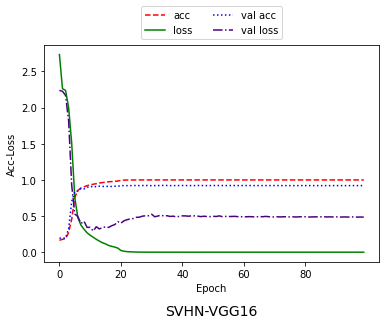

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('SVHN-VGG16', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [11]:
val_loss

[2.237729549407959,
 2.2246034145355225,
 2.168405532836914,
 1.813511610031128,
 0.9253526329994202,
 0.5299023985862732,
 0.4935552477836609,
 0.39806848764419556,
 0.429209440946579,
 0.34457558393478394,
 0.3449377715587616,
 0.29482409358024597,
 0.3528653681278229,
 0.3227207362651825,
 0.34172239899635315,
 0.3514403700828552,
 0.34342628717422485,
 0.36685699224472046,
 0.3828585743904114,
 0.42304477095603943,
 0.4025341272354126,
 0.43483009934425354,
 0.45063212513923645,
 0.4610685110092163,
 0.46635255217552185,
 0.4830593168735504,
 0.4851636588573456,
 0.49955329298973083,
 0.5042184591293335,
 0.5052124857902527,
 0.5257045030593872,
 0.4909236431121826,
 0.5010102391242981,
 0.5125242471694946,
 0.5014218688011169,
 0.5054657459259033,
 0.4954659044742584,
 0.499284565448761,
 0.4900629222393036,
 0.49583354592323303,
 0.503399670124054,
 0.5027204751968384,
 0.49879005551338196,
 0.5041963458061218,
 0.5032187700271606,
 0.4996422827243805,
 0.4931347668170929,
 0.498

In [12]:
val_acc

[0.1958743085433313,
 0.1958743085433313,
 0.1958743085433313,
 0.32909496004917027,
 0.7012907191149355,
 0.8400814382298709,
 0.8474569760295021,
 0.8823371235402582,
 0.8757298709280885,
 0.8989704978488015,
 0.8984326982175783,
 0.9168331284572834,
 0.9036186232329441,
 0.9142209588199139,
 0.9106100184388445,
 0.9089966195451752,
 0.9128764597418562,
 0.9092655193607867,
 0.9126843884449908,
 0.9126459741856177,
 0.9209050399508297,
 0.9220574677320221,
 0.9211355255070682,
 0.9211739397664414,
 0.9229025814382299,
 0.9222495390288875,
 0.9219422249539029,
 0.9229025814382299,
 0.9226336816226183,
 0.9241318377381684,
 0.9196757836508912,
 0.9217501536570375,
 0.9220574677320221,
 0.9238629379225568,
 0.9237092808850645,
 0.9233251382913338,
 0.9214428395820529,
 0.9222879532882606,
 0.9217117393976644,
 0.9227105101413645,
 0.9232098955132145,
 0.922480024585126,
 0.9218653964351567,
 0.9219038106945298,
 0.9218653964351567,
 0.9231330669944684,
 0.9225568531038721,
 0.9220574677

In [13]:
acc

[0.165485892133175,
 0.18013295657752842,
 0.18643952113791173,
 0.2735574757361071,
 0.4577446523881677,
 0.7570061564082613,
 0.8540344267442019,
 0.8874919802885731,
 0.9041866306291549,
 0.9211679429952087,
 0.930846198998048,
 0.9408657193169253,
 0.948045920526366,
 0.9572464064867521,
 0.9634028147480787,
 0.9683852737622344,
 0.9743642245792211,
 0.9773810011329975,
 0.98045237997734,
 0.98439739547074,
 0.9948537341141461,
 0.9975838486424505,
 0.9986076415905647,
 0.9990717610603764,
 0.9992628690773578,
 0.9996723862566035,
 0.9997815908377357,
 0.9998361931283017,
 0.9998634942735848,
 0.9998907954188678,
 0.9998771448462263,
 0.9999180965641509,
 0.9999317471367923,
 0.9999044459915093,
 0.9999180965641509,
 0.9999590482820754,
 0.9999590482820754,
 0.9999590482820754,
 0.9999453977094339,
 0.9999044459915093,
 0.9999453977094339,
 0.9999590482820754,
 0.9999453977094339,
 0.9999317471367923,
 0.9999180965641509,
 0.9999590482820754,
 0.9999590482820754,
 0.999931747136792

In [14]:
loss

[2.7329230740510626,
 2.2603029598342417,
 2.2375487757892145,
 1.998678483198744,
 1.504339010665641,
 0.7560216580949178,
 0.47855847082279285,
 0.3748849776771426,
 0.3192067424594733,
 0.2694483062946838,
 0.23603639658215986,
 0.20723616269511214,
 0.17945606471769485,
 0.1542240722228218,
 0.13197369782662974,
 0.11582496074979105,
 0.09456645644785842,
 0.08206268852959527,
 0.07187684352804975,
 0.05790281367815953,
 0.024919783765489062,
 0.014465462955084827,
 0.009182293238386005,
 0.006800142121306565,
 0.005063088069862981,
 0.0032758614336763497,
 0.002798443431568491,
 0.0022432650167670243,
 0.002104785229961261,
 0.001663635549267741,
 0.0016556920305029117,
 0.001832399129618498,
 0.001435466352967831,
 0.001579087236405347,
 0.0014479109757411122,
 0.0014573816066641907,
 0.00139982673696093,
 0.0014372051875829008,
 0.0015246882106425754,
 0.001779857039583834,
 0.0013872882712694073,
 0.0012697694796374398,
 0.001200275327211233,
 0.0012077857367653814,
 0.00131262